In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

# ระบุ path ของโฟลเดอร์ที่เก็บไฟล์
input_folder = r"C:\Users\BMEI CMU\Documents\G6PD\Dataset"
output_folder = r"C:\Users\BMEI CMU\Documents\G6PD\Cropped_Objects"

# ตรวจสอบว่าโฟลเดอร์ output มีอยู่หรือไม่ ถ้าไม่มีก็สร้างขึ้นมา
os.makedirs(output_folder, exist_ok=True)

# ฟังก์ชันสำหรับการแสดง Threshold ต่างๆ
def find_object_with_threshold(original_image, gray_image, threshold_value):
    # ใช้ Threshold เพื่อแยก object
    _, binary_image = cv2.threshold(gray_image, threshold_value, 255, cv2.THRESH_BINARY)
    
    # หา Contours ของ object
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # ตรวจสอบว่ามีวัตถุหรือไม่
    if len(contours) == 0:
        return None

    # วาด Contours และหาส่วนที่ใหญ่ที่สุด
    largest_contour = max(contours, key=cv2.contourArea)  # หา contour ที่มีขนาดใหญ่ที่สุด
    x, y, w, h = cv2.boundingRect(largest_contour)  # หาพื้นที่สี่เหลี่ยมที่ล้อมรอบ object

    # Crop เฉพาะส่วน object จากภาพต้นฉบับ
    cropped_object = original_image[y:y+h, x:x+w]
    
    return cropped_object, x, y, w, h

# วนลูปผ่านไฟล์ทั้งหมดในโฟลเดอร์
for file_name in os.listdir(input_folder):
    if file_name.endswith(".png") and ("-5" in file_name or "-15" in file_name):  # เลือกเฉพาะไฟล์ที่ตรงตามเงื่อนไข
        file_path = os.path.join(input_folder, file_name)

        # โหลดรูปภาพ
        image = cv2.imread(file_path)
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # แปลงเป็นภาพสีเทา

        # ทดลองค่า Threshold
        threshold_value = 5
        result = find_object_with_threshold(image, gray_image, threshold_value)

        if result is not None:
            cropped_object, x, y, w, h = result
            
            # บันทึกไฟล์ที่ crop
            save_path = os.path.join(output_folder, file_name)
            cv2.imwrite(save_path, cropped_object)
            #print(f"บันทึกไฟล์: {save_path}")
        else:
            #print(f"ไม่พบวัตถุในไฟล์: {file_name} ที่ Threshold: {threshold_value}")


In [ ]:
import cv2
import numpy as np
import os

# ระบุ path ของโฟลเดอร์ภาพ
input_folder = r"C:\Users\BMEI CMU\Documents\G6PD\Cropped_Objects"
output_folder = r"C:\Users\BMEI CMU\Documents\G6PD\Split_Images"

# สร้างโฟลเดอร์สำหรับบันทึกผลลัพธ์ (ถ้ายังไม่มี)
os.makedirs(output_folder, exist_ok=True)

# วนลูปอ่านไฟล์ในโฟลเดอร์
for file_name in os.listdir(input_folder):
    if file_name.endswith(".png") and ("-5" in file_name or "-15" in file_name):  # ตรวจสอบชื่อไฟล์
        file_path = os.path.join(input_folder, file_name)

        # โหลดภาพต้นฉบับแบบสี (BGR)
        image_color = cv2.imread(file_path, cv2.IMREAD_COLOR)
        image_rgb = cv2.cvtColor(image_color, cv2.COLOR_BGR2RGB)  # แปลงเป็น RGB

        # แปลงภาพเป็น Grayscale
        image_gray = cv2.cvtColor(image_color, cv2.COLOR_BGR2GRAY)

        # แบ่งภาพเป็น 3 ส่วนในแนวตั้ง
        height, width = image_gray.shape
        part_width = width // 3
        middle_section = image_gray[:, part_width:2 * part_width]  # ส่วนตรงกลาง

        # คำนวณค่าเฉลี่ยความเข้มแสงของพื้นที่ตรงกลาง
        middle_intensity = np.mean(middle_section, axis=0)

        # หาตำแหน่งที่ค่าความเข้มแสงต่ำที่สุดในส่วนกลาง
        middle_black_x_relative = np.argmin(middle_intensity)

        # คำนวณตำแหน่งที่แท้จริงในภาพต้นฉบับ
        middle_black_x = middle_black_x_relative + part_width

        # ตรวจสอบความถูกต้อง: หากค่าต่ำสุดไม่สมเหตุสมผล ให้ใช้การแบ่งครึ่งแทน
        if middle_black_x <= 0 or middle_black_x >= width:
            middle_black_x = width // 2

        # แบ่งภาพต้นฉบับออกเป็นซ้ายและขวา
        left_half = image_rgb[:, :middle_black_x, :]  # ส่วนซ้าย
        right_half = image_rgb[:, middle_black_x:, :]  # ส่วนขวา

        # บันทึกภาพซ้ายและขวา
        left_file_name = f"{os.path.splitext(file_name)[0]}_left.png"
        right_file_name = f"{os.path.splitext(file_name)[0]}_right.png"
        cv2.imwrite(os.path.join(output_folder, left_file_name), cv2.cvtColor(left_half, cv2.COLOR_RGB2BGR))
        cv2.imwrite(os.path.join(output_folder, right_file_name), cv2.cvtColor(right_half, cv2.COLOR_RGB2BGR))

        print(f"บันทึก: {left_file_name} และ {right_file_name} เรียบร้อย")

# สรุปผลลัพธ์
print(f"การแบ่งภาพเสร็จสมบูรณ์! ผลลัพธ์ถูกบันทึกในโฟลเดอร์: {output_folder}")

Label: 1
Area: 1.0
Centroid: (np.float64(9.0), np.float64(157.0))
Bbox: (9, 157, 10, 158)
Perimeter: 0.0
-----------------------------
Label: 2
Area: 107809.0
Centroid: (np.float64(178.88254227383612), np.float64(221.38325186208942))
Bbox: (15, 4, 357, 476)
Perimeter: 1989.2133829043455
-----------------------------
Label: 3
Area: 165.0
Centroid: (np.float64(22.721212121212123), np.float64(204.03030303030303))
Bbox: (18, 195, 29, 215)
Perimeter: 53.798989873223334
-----------------------------
Label: 4
Area: 1.0
Centroid: (np.float64(65.0), np.float64(100.0))
Bbox: (65, 100, 66, 101)
Perimeter: 0.0
-----------------------------
Label: 5
Area: 11.0
Centroid: (np.float64(160.0909090909091), np.float64(379.45454545454544))
Bbox: (158, 378, 163, 382)
Perimeter: 11.449747468305834
-----------------------------
Label: 6
Area: 66.0
Centroid: (np.float64(168.65151515151516), np.float64(370.030303030303))
Bbox: (160, 366, 179, 374)
Perimeter: 50.31370849898477
-----------------------------
Labe

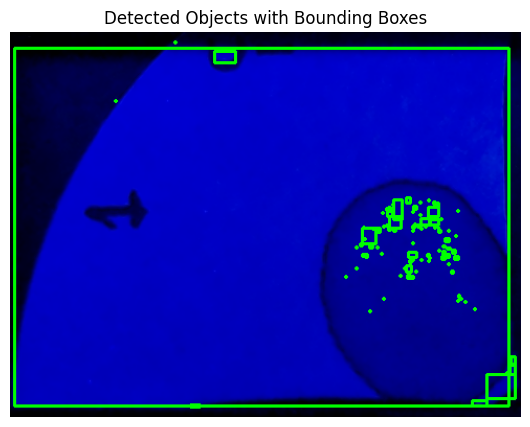

In [138]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops

# โหลดรูปภาพ
image_path = r'C:\Users\BMEI CMU\Documents\G6PD\Split_Images\1-15_left.png'
image = cv2.imread(image_path)

# แปลงเป็นภาพ grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# แปลงเป็นภาพไบนารี
_, binary = cv2.threshold(gray, 18, 255, cv2.THRESH_BINARY)

# สร้าง label (เชื่อมต่อแต่ละวัตถุในภาพ)
labeled_image = label(binary)

# ใช้ regionprops เพื่อวัดคุณสมบัติของวัตถุ
regions = regionprops(labeled_image)

# แสดงคุณสมบัติของแต่ละวัตถุ
for region in regions:
    print(f"Label: {region.label}")
    print(f"Area: {region.area}")
    print(f"Centroid: {region.centroid}")
    print(f"Bbox: {region.bbox}")  # Bounding box (min_row, min_col, max_row, max_col)
    print(f"Perimeter: {region.perimeter}")
    print("-----------------------------")

# วาด bounding boxes บนภาพต้นฉบับ
output_image = image.copy()

for region in regions:
    # Get bounding box coordinates
    min_row, min_col, max_row, max_col = region.bbox
    
    # วาดกรอบ bounding box บนภาพ
    cv2.rectangle(output_image, (min_col, min_row), (max_col, max_row), (0, 255, 0), 2)

# แสดงผลภาพ
plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.title("Detected Objects with Bounding Boxes")
plt.axis('off')
plt.show()
